In [7]:
def height_lut(sat='GPM'):

    x2=2.*17.0;
    re=6378.;
    theta=(-1.*x2/2+(x2/48.)*np.arange(50))*np.pi/180.;
    prheightref=np.zeros([176,49],'double')

    for i in np.arange(176):

        for j in np.arange(49):

            a=np.arcsin(((re+407.)/re)*np.sin(theta[j]))-theta[j];

            prheightref[i,j]=(176-i)*0.125*np.cos(theta[j]+a);

    return prheightref


def read_text(fname):
    fo=open(fname,'r') #create file object
    #headstr=fo.readline()
    data=fo.readlines()
    #print (data)
    fo.close()  # close object
    return data

# main
import os 
import matplotlib as mpl
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
#import matplotlib.ticker as mticker
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import glob
from pyhdf.SD import SD, SDC
import h5py


#fnames=glob.glob('/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2018/colocated_file_1505_parallax_2018059.0130.txt')
#fnames=glob.glob('/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/colocated_file_1505_parallax_2018310.1710.txt')

fnames=glob.glob('/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax*')
gpm_altitude=height_lut()
#print(fnames)

CFAD=np.zeros((100,176,2,11),'i') # dbz,altitude, latitude-0-trop,1-mid,probability
colocate_num=np.zeros((72,36),'i')

wfile=open('record_information_gpm_modis_1505_update_2014.txt','w')
hy5file='record_information_gpm_modis_cfad_number_2014.h5'

for fname in fnames:
    
    file_size=os.path.getsize(fname)
    
    if (file_size ==0):
        os.system('rm '+fname)

    if (file_size > 0) :
        print(fname,file_size)
        year_st=fname[83:87]
        day_st =fname[87:90]
        #print(year_st,day_st)
        start_date=date(int(year_st),1,1)
        convt_date=start_date+timedelta(days=int(day_st)-1)
        date_res  = convt_date.strftime("%m-%d-%y")
        month_st=date_res[0:2]
       
        data=read_text(fname)
        splitcol=data[0].split(' ')
        Ncol=len(splitcol)-splitcol.count('')
        Nrow=len(data)
        #print(Ncol,Nrow)
        # transfer data from string to float
        dataT=np.zeros((Nrow,Ncol),'f')
    
        for i in range(Nrow):
            splitcol=data[i].split(' ')
            #print(splitcol)
           
            k=0
            for j in range(len(splitcol)):
                if splitcol[j] != '' and splitcol[j] != '\n' :
                    if (k==8):
                        gpm_swnum=splitcol[j]
                    dataT[i,k]=float(splitcol[j])
                    k=k+1
                    #print(gpm_swnum)
            
            # read_hdf5 and get gpm data
            gpm_fname=glob.glob('/data/accp/a/snesbitt/gpmdata/radar/'+year_st+'/'+month_st+'/'+'*'+gpm_swnum+'*')
            #print(gpm_swnum,gpm_fname,fname)
            surf_alt = dataT[i,9]/1000.
            tp_OTlat = dataT[i,13]
            tp_OTlon = dataT[i,12]
            tropopause_hgt=dataT[i,4]
            OT_proba = dataT[i,14]
            #print(OT_proba,tp_OTlon,tp_OTlat)
            #print(tropopause_hgt)
            lat_scp = round((tp_OTlat+90-2.5)/5.0)
            lon_scp = round((tp_OTlon+180-2.5)/5.0)
            proba_scp=round(OT_proba/0.1)
            #print(proba_scp,OT_proba)
            colocate_num[lon_scp,lat_scp]=colocate_num[lon_scp,lat_scp]+1
            #print(lat_scp)
            #print(surf_alt,dataT)
            fid=h5py.File(gpm_fname[0],'r')
            #==read radar reflectivity =====
            #gpm_dbz = fid['NS/PRE/zFactorMeasured']
            gpm_dbz = fid['NS/SLV/zFactorCorrected']
          
                
            gpm_dbz_size=gpm_dbz.shape
            nray_scp=int(dataT[i,0])-1
            nscan_scp=int(dataT[i,1])-1
            nscan_x1=nscan_scp-8
            nscan_x2=nscan_scp+8
            nray_x1 =nray_scp-8
            nray_x2 =nray_scp+8 # parallax may cause 20 km biases, OT diameter ~ 20 km, storm moving distance max ~18 km(assuming wind speed 30 m/s)
            
            if (nscan_x1 <0):
                nscan_x1=0
            if (nscan_x2 > gpm_dbz_size[0]-1):
                nscan_x2=gpm_dbz_size[0]-1
            if (nray_x1 < 0):
                nray_x1=0
            if (nray_x2 > gpm_dbz_size[1]-1):
                nray_x2=gpm_dbz_size[1]-1
            
            # visulization 
            #plt.figure()
            #dbz_along=gpm_dbz[nscan_scp,0:48,:]
            #p=plt.imshow(dbz_along,vmin=0,vmax=30,cmap=plt.get_cmap('gist_gray'),aspect='auto')
            
            #tp_altitude=gpm_altitude[:,nray_scp]
            
            #plt.plot(gpm_dbz[nscan_scp,nray_scp,:],gpm_altitude[:,nray_scp])
            #plt.xlim([0,60])
            # get the CFAD in 41x41 km2 centered to the OT candidate, being consistent with the the OT method
            tp_gpm_dbz =gpm_dbz[nscan_x1:nscan_x2,nray_x1:nray_x2,:]
            tp_altitude=gpm_altitude[:,nray_x1:nray_x2]
            #print(tp_gpm_dbz.shape,tp_altitude.shape)
            dim_size=tp_gpm_dbz.shape
     
          
            ave_dbz = np.zeros(dim_size[2],'i')
            ave_dbz20 = np.zeros(dim_size[2],'i')
            ave_gpm_alt=np.mean(tp_altitude,axis=1)
            
            for gi in range(dim_size[0]):
                for gj in range(dim_size[1]):
                    tp_gpm_dbz_1=tp_gpm_dbz[gi,gj,:]
                    tp_altitude_1=tp_altitude[:,gj]
                    #print(tp_gpm_dbz_1.shape,tp_altitude_1.shape)
                    index=np.where(tp_gpm_dbz_1 >= 15) # only consider dbz > 15
                    x=index[0]
                    
                    for gz in x:
                        if(tp_altitude_1[gz] > surf_alt):
                            #print(gz,tp_altitude_1[gz],tp_gpm_dbz_1[gz])
                            dbz_scp = round(tp_gpm_dbz_1[gz])
                            ave_dbz[gz] = ave_dbz[gz] +1
                            
                            if abs(tp_OTlat) <= 25:
                                CFAD[dbz_scp,gz,0,proba_scp]=CFAD[dbz_scp,gz,0,proba_scp]+1
                            
                            if abs(tp_OTlat) > 25:
                                CFAD[dbz_scp,gz,1,proba_scp]=CFAD[dbz_scp,gz,1,proba_scp]+1
                                      
                            if (tp_gpm_dbz_1[gz] >= 20):
                                ave_dbz20[gz]=ave_dbz20[gz]+1
                            
            storm_flag=0
            overshoot_flag=0
            cloud_flag=0
            
            index=np.where(ave_dbz >0)
            index=index[0]
            #print('tropopause',tropopause_hgt)
            #print(len(index),index)
            if (len(index) > 1):
                ind_loc=index[0]
                #print(ave_gpm_alt[ind_loc])
                if (ave_gpm_alt[ind_loc] > (tropopause_hgt-2)):
                    overshoot_flag=1
                if (ave_gpm_alt[ind_loc] > surf_alt+1):
                    cloud_flag=1
                    
            #print(overshoot_flag,'overshoot falg',ave_gpm_alt[ind_loc])
            index=np.where(ave_dbz20 >0)
            index=index[0]
            if (len(index) >1):
                ind_loc=index[0]
                if (abs(tp_OTlat) > 30 and ave_gpm_alt[ind_loc] > 5 ):
                    storm_flag=1
                if (abs(tp_OTlat) <=30 and ave_gpm_alt[ind_loc] > 10):
                    storm_flag=1
            
            #print(overshoot_flag,storm_flag,cloud_flag)
            wfile.write(str(tp_OTlon)+' '+str(tp_OTlat)+' '+str(OT_proba)+'  '+str(overshoot_flag)+' '+str(storm_flag)+'  '+str(cloud_flag)+' '+fname+'\n') # write for each row
            
            #plt.plot(ave_dbz,tp_altitude_1)
            #plt.plot(ave_dbz20,tp_altitude_1,'r')
            #plt.show()
            
            #x=np.arange(100)
            #print(CFAD.shape)
            #plt.contour(x,tp_altitude_1,np.transpose(CFAD[:,:,16]))
            #plt.xlim([10,60])
                            
wfile.close() # end search all files   
#=== to write hdf5 ====
hf=h5py.File(hy5file,'w')
hf.create_dataset('CFAD',data=CFAD)
hf.create_dataset('Colocated_number',data=colocate_num)
hf.close()

print('finish')

/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014078.1105.txt 1336
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014078.1645.txt 2004
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014080.1140.txt 2004
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014081.1445.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014081.1540.txt 1336
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014082.1445.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014082.1700.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014082.1750.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014082.2345.txt 6012
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/coloc

/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014159.2315.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014160.1820.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014160.2135.txt 5344
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014161.0455.txt 4008
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014161.1900.txt 2672
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014161.2045.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014162.0135.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014162.1805.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014162.1945.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocat

/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014221.2105.txt 1336
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014221.2245.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014222.2010.txt 1336
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014222.2150.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014226.0320.txt 2672
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014237.0350.txt 2004
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014239.0245.txt 2004
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014239.0830.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014240.0330.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/coloc

/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014292.0430.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014294.1055.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014294.1550.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014295.0155.txt 1336
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014295.0510.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014295.0650.txt 5344
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014295.1145.txt 668
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014296.0415.txt 3340
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/colocated_file_1505_parallax_2014296.0735.txt 1336
/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2014/coloca

(100, 176, 11)


Text(0, 0.5, 'Altitude (km)')

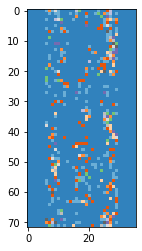

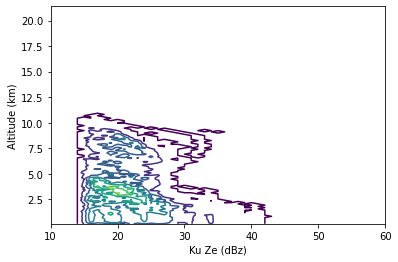

In [8]:
#print(np.sum(colocate_num))
plt.figure()
p2=plt.imshow(colocate_num,vmin=0,vmax=10,cmap=plt.get_cmap('tab20c'))

plt.figure()
x=np.arange(100)
            #print(CFAD.shape)
CFAD1=np.sum(CFAD,axis=2)
print(CFAD1.shape)
CFAD2=CFAD1[:,:,1]
plt.contour(x,tp_altitude_1,np.transpose(CFAD2))
plt.xlim([10,60])
plt.xlabel('Ku Ze (dBz)')
plt.ylabel('Altitude (km)')
                            